In [1]:
!pip install mkl
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version "nightly"
!pip install vision_transformer_pytorch

     |████████████████████████████████| 291.3 MB 16 kB/s 
     |████████████████████████████████| 2.0 MB 40.8 MB/s 
     |████████████████████████████████| 3.9 MB 40.1 MB/s 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  69135      0 --:--:-- --:--:-- --:--:-- 69135
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
Found existing installation: torch 1.7.0
Uninstalling torch-1.7.0:
  Successfully uninstalled torch-1.7.0
Found existing installation: torchvision 0.8.1
Uninstalling torchvision-0.8.1:
Done updating TPU runtime
  Successfully uninstalled torchvision-0.8.1
Copying gs://tpu-pytorch/wheels/torch-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/135.2 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp37-cp37m-linux_x86_64.whl...

Ope

In [2]:
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/anaconda3/envs/torch-xla-nightly/lib

In [3]:
import os 

import torch_xla
import torch_xla.debug.metrics as met
import torch_xla.distributed.data_parallel as dp
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.utils.serialization as xser
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.test.test_utils as test_utils

import torch as T
from torch.utils.data import Dataset, DataLoader
from torch import nn
from vision_transformer_pytorch import VisionTransformer
from torch.nn import functional as F
from torch import optim


import cv2
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
import random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import gc

/opt/conda/lib/python3.7/site-packages/torch/package/_directory_reader.py:17: UserWarning: Failed to initialize NumPy: module compiled against API version 0xe but this version of numpy is 0xd (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:68.)
  _dtype_to_storage = {data_type(0).dtype: data_type for data_type in _storages}


In [4]:
#os.environ["XLA_USE_BF16"] = "1"
#os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

In [5]:
root_path = "../input/seti-breakthrough-listen"
train_path = os.path.join(root_path, "train")
test_path  = os.path.join(root_path, "test")
targets = pd.read_csv("../input/seti-breakthrough-listen/train_labels.csv")

#hyperparameters

(6, 273, 256)
../input/seti-breakthrough-listen/train/4/4e544064d5d0.npy
[0]


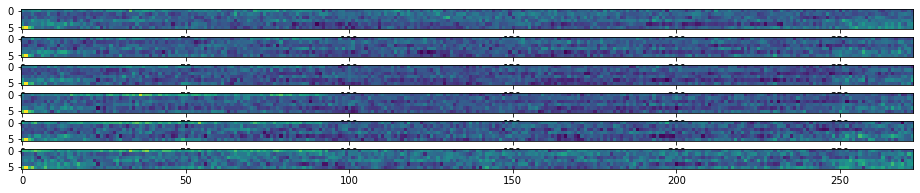

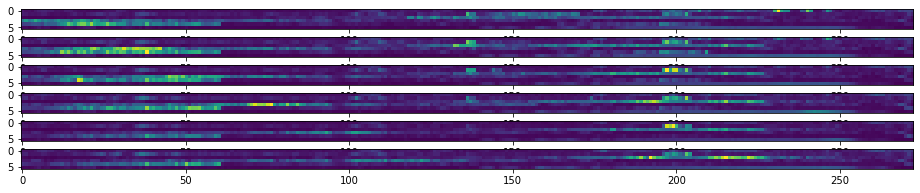

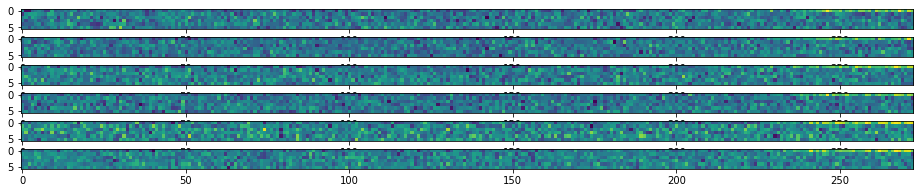

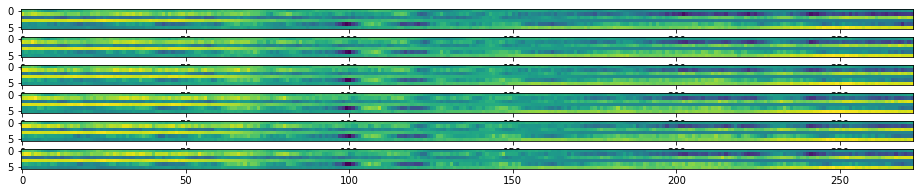

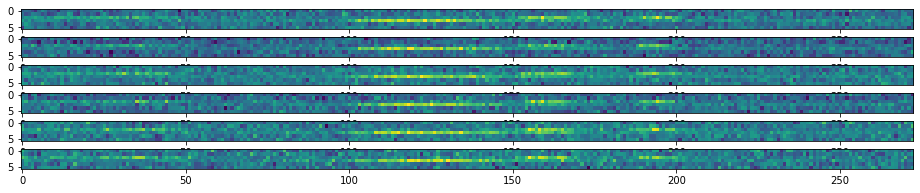

In [6]:
def random_plot():
    folders = os.listdir(train_path)
    folders = random.choices(folders, k = 5)
    for i,folder in enumerate(folders):
        fig,ax = plt.subplots(6,1, figsize = (16,3))
        folder_path = os.path.join(train_path, folder)
        files = os.listdir(folder_path)
        file = random.choice(files)
        img = np.load(os.path.join(folder_path,file))
        for i in range(6):
            ax[i].imshow(img[:,:,i].astype(float))
    print(img.shape)
    print(os.path.join(folder_path,file))
    print(targets[targets.id==file.split(".")[0]].target.to_numpy())
random_plot()

In [7]:
import albumentations as A
img_sz = 384
ttransform = A.Compose([
    A.Resize(img_sz, img_sz, cv2.INTER_NEAREST),
    A.VerticalFlip(p=0.4),
    A.HorizontalFlip(p=0.4),
])
vtransform = A.Compose([
    A.Resize(img_sz, img_sz, cv2.INTER_NEAREST)
])

In [8]:
class setiDataset(Dataset):
    def __init__(self, files, labels, tr):
        self.files = files
        self.labels = labels
        self.tr = tr
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        img = np.load(file)
        image = np.vstack(img).astype(float)
        image = self.tr(image = image)["image"][np.newaxis, ]
        target = self.labels[idx].astype(float)
        return T.tensor(image), T.tensor(target)

In [9]:
targets['img_path'] = targets['id'].apply(lambda x: f'../input/seti-breakthrough-listen/train/{x[0]}/{x}.npy')
targets.head()

,id,target,img_path
0,00034abb3629,0,../input/seti-breakthrough-listen/train/0/0003...
1,0004300a0b9b,0,../input/seti-breakthrough-listen/train/0/0004...
2,000453852fda,0,../input/seti-breakthrough-listen/train/0/0004...
3,00047dfc96a9,0,../input/seti-breakthrough-listen/train/0/0004...
4,0004be0baf70,0,../input/seti-breakthrough-listen/train/0/0004...


In [10]:
class ViT(nn.Module):
    def __init__(self,device="cpu"):
        super().__init__()
        self.transformer = VisionTransformer.from_pretrained('ViT-B_16', num_classes = 1)
        self.conv = nn.Conv2d(1, 3, kernel_size=(1, 1))
        self.device = device
        self.to(device)
        #print(l)
    def forward(self, X):
        X = X.to(self.device).float()
        X = self.conv(X)
        X = self.transformer(X)
        return T.sigmoid(X)
model = ViT()
dummy = T.rand((1,1,384,384))
model(dummy).size()

Downloading: "https://github.com/tczhangzhi/VisionTransformer-PyTorch/releases/download/1.0.1/ViT-B_16_imagenet21k_imagenet2012.pth" to /root/.cache/torch/hub/checkpoints/ViT-B_16_imagenet21k_imagenet2012.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

Loaded pretrained weights for ViT-B_16


torch.Size([1, 1])

In [11]:
#hyperparametrs
FOLDS = 6
BATCH_SIZE = 40
NUM_WORKERS = 2
EPOCHS = 6
LR = 0.001*xm.xrt_world_size()
DEVICE = xm.xla_device()

In [12]:
def focal_loss(Y_true, Y_pred, gamma = 2):
    l = Y_true*((1-Y_pred)**gamma)*T.log(Y_pred)+(1-Y_true)*(Y_pred**gamma)*T.log(1-Y_pred)
    return -l

def train_one_epoch(model, optimizer, dataloader, device):
    length = len(dataloader)
    dataloader = tqdm(dataloader)
    dataloader = enumerate(dataloader)
    model.to(device)
    model.train()
    total_loss = 0
    total_accuracy = 0
    for i,(X,Y) in dataloader:
        X = X.to(device).float()
        Y = Y.to(device).float()
        y = model(X)
        optimizer.zero_grad() 
        #print(y.size(),Y.size())
        L = focal_loss(Y,y)
       
        L.mean().backward()
        xm.optimizer_step(optimizer)
        total_loss+=L.mean().item()
        output = y.detach().clone()
        output[output>0.5] = 1.0
        output[output<=0.5] = 0.0
        accuracy = (output == Y).float().mean()
        total_accuracy+=accuracy
    total_accuracy/=length
    total_loss/=length
    del dataloader 
    return total_loss, total_accuracy

def validate_one_epoch(model, dataloader, device):
    model.to(device)
    model.eval()
    length = len(dataloader)
    dataloader = tqdm(dataloader)
    dataloader = enumerate(dataloader)
    total_accuracy = 0 
    total_loss = 0
    for i,(X,Y) in dataloader:
        X = X.to(device).float()
        Y = Y.to(device).float()
        y = model(X)
        #print(y.size(),Y.size())
        L = focal_loss(Y, y)
        total_loss+=L.mean().item()
        output = y.detach().clone()
        output[output>0.5] = 1.0
        output[output<=0.5] = 0.0
        accuracy = (output==Y).float().mean()
        total_accuracy+=accuracy
    del dataloader
    return total_loss/length, total_accuracy/length


In [13]:
skf = StratifiedKFold(FOLDS,shuffle=True,random_state=42)
files = targets.img_path.values
labels = targets.target.values
model = ViT(DEVICE)

for fold,(train_idx, valid_idx) in enumerate(skf.split(files, labels)):
    best_Acc = 0
    train_dataset = (files[train_idx], labels[train_idx])
    valid_dataset = (files[valid_idx][:1500], labels[valid_idx][:1500])
    
    train_dataset = setiDataset(*train_dataset,ttransform)
    valid_dataset = setiDataset(*valid_dataset,ttransform)
    
    
    train_sampler = T.utils.data.distributed.DistributedSampler(
            train_dataset,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=True)


    valid_sampler = T.utils.data.distributed.DistributedSampler(
            valid_dataset,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=False,
            )

    
    train_dataloader = DataLoader(train_dataset,
                                 batch_size = BATCH_SIZE,
                                 sampler=train_sampler,
                                 drop_last=True,
                                 num_workers = NUM_WORKERS)
    valid_dataloader = DataLoader(valid_dataset,
                                 batch_size = BATCH_SIZE,
                                 num_workers = NUM_WORKERS,
                                 sampler=valid_sampler,
                                 drop_last=True)
    
    optimizer = optim.Adam(model.parameters(), LR)
    best_file = "FOLD_{}.pth".format(fold)
    
    for epoch in range(EPOCHS):
        para_loader = pl.ParallelLoader(train_dataloader, [DEVICE])
        para_loader = para_loader.per_device_loader(DEVICE)
        loss, accuracy = train_one_epoch(model, optimizer, para_loader, DEVICE)
        del para_loader
        gc.collect()
        
        para_loader = pl.ParallelLoader(train_dataloader, [DEVICE])
        para_loader = para_loader.per_device_loader(DEVICE)
        val_loss, val_accuracy = validate_one_epoch(model, valid_dataloader, DEVICE)
        del para_loader
        gc.collect()
        
        xm.master_print("epoch {} | loss : {} | acc : {} | val loss : {} | val acc : {}".format(
                                                                                epoch, loss, accuracy,
                                                                                val_loss, val_accuracy))
        if best_Acc<val_accuracy:
            xm.save(model.state_dict(), best_file)
            best_Acc = val_accuracy
    break

Loaded pretrained weights for ViT-B_16


  0%|          | 0/1045 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 0 | loss : 0.0872047466752358 | acc : 0.9055688381195068 | val loss : 0.08151758532669093 | val acc : 0.912162184715271


  0%|          | 0/1045 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 | loss : 0.08508114483938263 | acc : 0.9064109921455383 | val loss : 0.08110170730867901 | val acc : 0.912162184715271


  0%|          | 0/1045 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 | loss : 0.08490665658203324 | acc : 0.9064109921455383 | val loss : 0.0810547229405996 | val acc : 0.912162184715271


  0%|          | 0/1045 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 | loss : 0.08481720906089653 | acc : 0.9064109921455383 | val loss : 0.08104586712009199 | val acc : 0.912162184715271


  0%|          | 0/1045 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 | loss : 0.08477645082907244 | acc : 0.9064109921455383 | val loss : 0.08104585403123417 | val acc : 0.912162184715271


  0%|          | 0/1045 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 | loss : 0.08473570489248876 | acc : 0.9064109921455383 | val loss : 0.08104643346490087 | val acc : 0.912162184715271
